In [9]:
import jax
import jax.numpy as jnp
from jax import grad, jit
import optax  
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from mpl_toolkits.mplot3d import Axes3D

seed = 45
key = jax.random.PRNGKey(seed)

# Parameters
n_agents = 14
n_steps = 10
true_theta = jnp.array([4, 0.25])
# parameters gamma (describes the x - discrepancy), tau, nu
true_Omega_parameters = jnp.array([20, 0.75, 40])
T = 1

K_channels = n_agents  # can be changed to test the effect of media - type controls. In this project always equal to n_agents
t = jnp.linspace(0, T, n_steps)  # Time grid
dt = t[1] - t[0]

@jit
def func(positions, controls, theta):
    """
    Compute the forces acting on each particle given their positions, parameters (theta = (alpha, c)), and control values.

    Args:
        positions (list of float): A list of length N representing the positions of the particles at time t.
        theta (float): Parameters [alpha, c] of the CS kernel.
        controls (list of float): A list of length N representing the control values at time t.

    Returns:
        list of float: A list of length N representing the forces acting on each particle at time t.
    """
    alpha = theta[0]
    c = theta[1]

    def pairwise_forces(i, positions, c, alpha):
        distances = positions - positions[i]
        forces = (distances * c) / ((jnp.abs(distances) ** 2 + 1) ** alpha)
        forces = forces.at[i].set(0)  # Set force on itself to 0
        return jnp.sum(forces, axis=0)

    forces = jax.vmap(pairwise_forces, in_axes=(0, None, None, None))(jnp.arange(positions.shape[0]), positions, c, alpha)

    forces += controls
    return forces
@jit
def rk4_step(x, u, dt, theta_coefficients):
    """Computes the next positions of the particles using the Runge-Kutta 4th order method

    Args:
        x (list of float): A list of length N representing the positions of the particles at time t.
        u (list of float): A list of length N representing the control values at time t.
        dt (float): time step
        theta_coefficients (float, float): Parameters [alpha, c] of the CS kernel.

    Returns:
        (list of float): A list of length N representing the positions of the particles at time t + dt.
    """
    k1 = dt * func(x, u, theta_coefficients)
    k2 = dt * func(x + 0.5 * k1, u, theta_coefficients)
    k3 = dt * func(x + 0.5 * k2, u, theta_coefficients)
    k4 = dt * func(x + k3, u, theta_coefficients)
    return x + (k1 + 2*k2 + 2*k3 + k4) / 6

@jit
def forward_pass(x_0, u_grid, theta_coefficients):
    """Computes the positions of the particles at each time step using the Runge-Kutta 4th order method

    Args:
        x_0 (float of len N): initial postinions of the particles
        u_grid (float of dim N x (K+1)): control values at each time step and for each particle
        theta_coefficients (float, float): parameters of the CS kernel

    Returns:
        x_grid (float of dim N x (K+1)): positions of the particles at each time step
    """
    x_grid = jnp.zeros((n_agents, n_steps))
    x_grid = x_grid.at[:, 0].set(x_0)
    for i in range(1, n_steps):
        x = x_grid[:, i-1]
        u = u_grid[:, i-1]
        x_grid = x_grid.at[:, i].set(rk4_step(x, u, dt, theta_coefficients))
    return x_grid

def compute_J(x_grid, u_grid, theta_coefficients, Omega_parameters):
    """Computes the cost function J_Omega for a given trajectory, and parameters Omega

    Args:
        x_grid (float of dim N x (K+1)): positions of the particles at each time step
        u_grid (float of dim N x (K+1)): control values at each time step and for each particle
        theta_coefficients (float, float): parameters of the CS kernel
        Omega_parameters (float, float, float): scaled down parameters of the loss function

    Returns:
        float: the value of the cost functional J_Omega
    """
    
    # Rescale Omega parameters
    rescaled_Omega_parameters = jnp.array([10, 1, 10]) * Omega_parameters
    gamma, x_hat, nu = rescaled_Omega_parameters

    # Compute the running cost J
    x_means = jnp.mean(x_grid[:, :n_steps], axis=0)
    x_diffs = x_grid[:, :n_steps] - x_means
    u_squares = jnp.square(u_grid[:, :n_steps])

    running_j = dt * jnp.sum(gamma * jnp.sum(jnp.square(x_diffs), axis=0) + jnp.sum(u_squares, axis=0))

    # Handle the final step separately to compute the terminal cost
    x_final = x_grid[:, n_steps - 1]
    phi = nu * jnp.dot(x_final - x_hat, x_final - x_hat)

    # Compute the final cost J
    J = running_j + phi
    return J

@jit
def compute_loss(u, x_0, theta_coefficients, Omega_parameters):
    """calls on the forward pass and compute_J functions to compute the loss function

    Args:
        u (float vector): control values before reshaping into a matrix
        x_0 (float of len N): initial postinions of the particles
        theta_coefficients (float, float): parameters of the CS kernel
        Omega_parameters (float, float, float): scaled down parameters of the loss function

    Returns:
        float: the value of the cost functional J_Omega
    """
    u_grid = u.reshape((K_channels, n_steps))
    x_grid = forward_pass(x_0, u_grid, theta_coefficients)
    return compute_J(x_grid, u_grid, theta_coefficients, Omega_parameters)

def run_optimization(x_0, theta_coefficients, Omega_parameters):
    """finds the optimal control signal u

    Args:
        x_0 (float of len N): initial postinions of the particles
        theta_coefficients (float, float): parameters of the CS kernel
        Omega_parameters (float, float, float): scaled down parameters of the loss function J

    Returns:
        u (float vector): control values before reshaping into a matrix
    """
    optimizer = optax.adam(learning_rate=0.05)
    gradient_u = lambda u: grad(compute_loss, argnums=0)(u, x_0, theta_coefficients, Omega_parameters)

    @partial(jit, static_argnums=(2,))
    def update_step(u, opt_state, n_agents):
        grads = gradient_u(u)
        updates, opt_state = optimizer.update(grads, opt_state)
        u = optax.apply_updates(u, updates)
        return u, opt_state

    u_init = jnp.zeros(K_channels * n_steps)
    opt_state = optimizer.init(u_init)
    u = u_init
    last_loss_values = []
    for i in range(50):  # Number of optimization steps
        u, opt_state = update_step(u, opt_state, n_agents)
        if i > 40:  # check convergence
            last_loss_values.append(compute_loss(u, x_0, theta_coefficients, Omega_parameters))

    have_converged = (max(last_loss_values) - min(last_loss_values)) / min(last_loss_values)
    while have_converged > 0.001:
        last_loss_values = []
        for i in range(20):  # Number of optimization steps
            u, opt_state = update_step(u, opt_state, n_agents)
            if i > 15:  # check convergence
                last_loss_values.append(compute_loss(u, x_0, theta_coefficients, Omega_parameters))
        have_converged = (max(last_loss_values) - min(last_loss_values)) / min(last_loss_values)
    return u

def find_u_grid(n_agents, n_steps, dt, x_0, theta_coefficients, Omega_parameters):
    """calls on the run_optimization function to find the optimal control signal u, and reshapes it into a matrix

    Args:
        n_agents (int): N in the report, numer of agents
        n_steps (int): K in the reprt, number of time steps
        dt (float): time step
        x_0 (float of len N): initial postinions of the particles
        theta_coefficients (float, float): parameters of the CS kernel
        Omega_parameters (float, float, float): scaled down parameters of the loss function J

    Returns:
        N x (K+1) matrix of float: control values at each time step and for each particle
    """
    K_channels = n_agents
    u = run_optimization(x_0, theta_coefficients, Omega_parameters)
    u_grid = u.reshape((K_channels, n_steps))
    return u_grid

#### helper functions for plotting ####
def plot_x(x_grid, n_agents, t, title=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(n_agents):
        ax.plot(t, x_grid[i], label=f'Agent {i+1}', linewidth=1.5)
    ax.set_xlabel('Time [s]', fontsize=12)
    ax.set_ylabel('State $x^{obs}$', fontsize=12)
    if title:
        ax.set_title(title, fontsize=14)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_u(u_grid, K_channels, t, title=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(K_channels):
        ax.plot(t, u_grid[i], label=f'Channel {i+1}', linewidth=1.5)
    ax.set_xlabel('Time [s]', fontsize=12)
    ax.set_ylabel('Control Signal', fontsize=12)
    if title:
        ax.set_title(title, fontsize=14)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True)
    plt.tight_layout()
    plt.show()


key, subkey = jax.random.split(key)
x0 = jax.random.uniform(subkey, (n_agents,), minval=-1, maxval=1)

scaled_Omega_parameters = jnp.array([0.1, 1, 0.1]) * true_Omega_parameters
u_observed = find_u_grid(n_agents, n_steps, dt, x0, true_theta, scaled_Omega_parameters)
x_observed = forward_pass(x0, u_observed, true_theta)



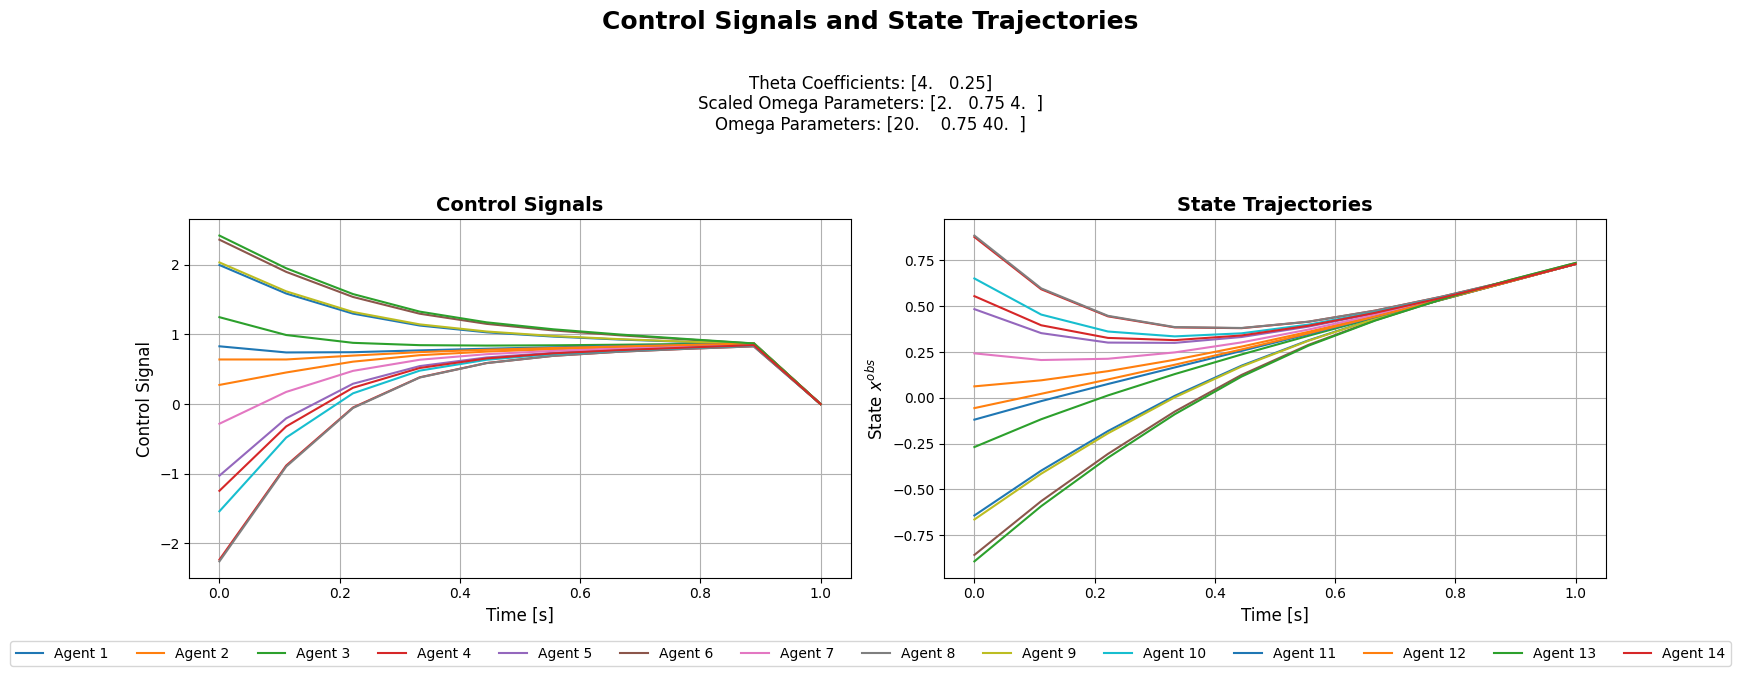

In [10]:
def plot_the_trajectories(u, x_0, theta, dt, n_agents, n_steps, t, scaled_Omega_parameters):
    # function for plotting the control signals and state trajectories. Used for visualization purposes.
    K_channels = n_agents
    u_grid = u.reshape((K_channels, n_steps))
    x_grid = forward_pass(x_0, u_grid, theta)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    main_title = 'Control Signals and State Trajectories'
    subtitle = (
        f'Theta Coefficients: {theta}\n'
        f'Scaled Omega Parameters: {scaled_Omega_parameters}\n'
        f'Omega Parameters: {jnp.array([10,1,10]) * scaled_Omega_parameters}'
    )

    fig.suptitle(main_title, fontsize=18, fontweight='bold', y=1.10)
    fig.subplots_adjust(top=0.75)
    fig.text(0.5, 0.90, subtitle, ha='center', fontsize=12)

    for j in range(n_agents):
        axes[0].plot(t, u_grid[j], label=f'Agent {j + 1}', linewidth=1.5)
        axes[1].plot(t, x_grid[j], label=f'Agent {j + 1}', linewidth=1.5)

    axes[0].set_title("Control Signals", fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time [s]', fontsize=12)
    axes[0].set_ylabel('Control Signal', fontsize=12)
    axes[0].grid(True)

    axes[1].set_title("State Trajectories", fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time [s]', fontsize=12)
    axes[1].set_ylabel('State $x^{obs}$', fontsize=12)
    axes[1].grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=n_agents, fontsize=10)
    plt.tight_layout(rect=[0, 0.05, 1, 0.88])
    plt.show()

plot_the_trajectories(u_observed, x0, true_theta, dt, n_agents, n_steps, t, scaled_Omega_parameters)


In [45]:
# Maximum Likelihood Estimation to estimate true_theta
def likelihood_loss(theta, x0, u_observed, x_observed):
    """returns D(theta) as described in 2.1.1

    Args:
        theta (float, float): parameters of the CS kernel
        x0 (float of len N): initial postinions of the particles
        u_observed (float of dim N x (K+1)): observed control values at each time step and for each particle
        x_observed (float of dim N x (K+1)): observed positions of the particles at each time step

    Returns:
        float: returns D(theta)
    """
    x_pred = forward_pass(x0, u_observed, theta)
    loss = jnp.sum((x_pred - x_observed)**2)  # Compute the loss as the sum of squared differences
    return loss

def estimate_parameters(x0, u_observed, x_observed):
    """ Gradient descent optimization to estimate the parameters theta

    Args:
        x0 (float of len N): initial postinions of the particles
        u_observed (float of dim N x (K+1)): observed control values at each time step and for each particle
        x_observed (float of dim N x (K+1)): observed positions of the particles at each time step


    Returns:
        (float, float): estimated parameters of the CS kernel
    """
    initial_theta = jnp.array([1.0, 0.5])  # Initial guess for theta
    optimizer = optax.adam(learning_rate=0.05)

    @jit
    def update_step(theta, opt_state):
        loss_value, grads = jax.value_and_grad(likelihood_loss)(theta, x0, u_observed, x_observed)
        updates, opt_state = optimizer.update(grads, opt_state)
        theta = optax.apply_updates(theta, updates)
        return theta, opt_state, loss_value

    opt_state = optimizer.init(initial_theta)
    theta = initial_theta
    for i in range(2000):  # Number of optimization steps
        theta, opt_state, loss_value = update_step(theta, opt_state)
        if i % 100 == 0:
            print(f'Step {i}, Loss: {loss_value}, Theta: {theta}')

    return theta

estimated_theta = estimate_parameters(x0, u_observed, x_observed)

Step 0, Loss: 1.7807751893997192, Theta: [1.0499997  0.45000035]
Step 100, Loss: 0.011051499284803867, Theta: [2.0833056  0.16241013]
Step 200, Loss: 0.006498510483652353, Theta: [2.471513   0.17936346]
Step 300, Loss: 0.0035376104060560465, Theta: [2.8314424  0.19547744]
Step 400, Loss: 0.0018474869430065155, Theta: [3.1307976  0.20912986]
Step 500, Loss: 0.0009336895891465247, Theta: [3.368132   0.22011015]
Step 600, Loss: 0.00045610341476276517, Theta: [3.550892   0.22865792]
Step 700, Loss: 0.00021435432427097112, Theta: [3.6882908 0.2351365]
Step 800, Loss: 9.634915477363393e-05, Theta: [3.7891562  0.23992102]
Step 900, Loss: 4.116543641430326e-05, Theta: [3.861329   0.24335927]
Step 1000, Loss: 1.6614223568467423e-05, Theta: [3.911535   0.24575828]
Step 1100, Loss: 6.297108484432101e-06, Theta: [3.9453921  0.24737948]
Step 1200, Loss: 2.2285203158389777e-06, Theta: [3.9674623  0.24843775]
Step 1300, Loss: 7.324040325329406e-07, Theta: [3.9813313  0.24910334]
Step 1400, Loss: 2.22

true Omega parameters: [20.    0.75 40.  ]
scaled Omega parameters (what the function should return): [2.   0.75 4.  ]
using the estimated parameters theta = [3.9998894  0.24999467]
Iteration: 0, Parameters: [1. 0. 1.], Controls discrepancy: 94.79769897460938
Gradient estimation from the finite difference: [  -0.76293945 -233.61206       0.        ]
Iteration: 1, Parameters: [1.1999998  0.19999985 1.        ], Controls discrepancy: 53.74327850341797
Gradient estimation from the finite difference: [  -1.1444092 -174.63684     -4.119873 ]
Iteration: 2, Parameters: [1.3979888 0.3965797 1.1484917], Controls discrepancy: 24.48179817199707
Gradient estimation from the finite difference: [  -1.0108948 -118.04581     -4.558563 ]
Iteration: 3, Parameters: [1.5969493 0.585648  1.3199912], Controls discrepancy: 7.086301803588867
Gradient estimation from the finite difference: [ -1.1205673 -61.745644   -3.3283234]
Iteration: 4, Parameters: [1.7968831 0.7603903 1.4988859], Controls discrepancy: 0.9

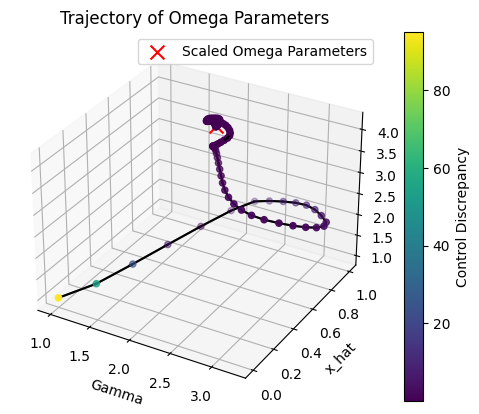

In [46]:
def discrepancy_of_optimal_controls_2(Omega_test, theta_coefficients):
    """implements the function E(Omega) as described in 4.1

    Args:
        Omega_test (flaot, float, float): parameters Omega of the loss function J
        theta_coefficients (flaot, float): parameters of the CS kernel

    Returns:
        flaot: E_theta(Omega) = ||u_optimal_Omega - u_observed||^2 + ||x_optimal_Omega - x_observed||^2
    """
    u_optimal_Omega = find_u_grid(n_agents, n_steps, dt, x0, theta_coefficients, Omega_test)

    x_optimal_Omega = forward_pass(x0, u_optimal_Omega, theta_coefficients)

    if u_optimal_Omega is None: # If the optimization fails, return a large value
        print("Optimization failed, returning a large value")
        return 0.1

    return jnp.linalg.norm(u_optimal_Omega - u_observed, ord=2)**2 + jnp.linalg.norm(x_optimal_Omega - x_observed, ord=2)**2

def find_Omega_parameters( theta_coefficients):
    """Implement the optimization algorithm to find the Omega parameters with finite difference gradients

    Args:
        theta_coefficients (flaot, float): parameters of the CS kernel
    Returns:
        \hat{Omega} parameters (float, float, float); estimates for the Omega parameters
        Omega_trajectory (list of float): trajectory of the Omega parameters during the optimization
        control_discrepancies (list of float): control discrepancies at each iteration
    """
    # Parameters gamma (for x consensus), x_hat, nu
    Omega_parameters = jnp.array([1.0, 0.0, 1.0])

    # Define the optimizer
    learning_rate = 0.2
    optimizer = optax.adam(learning_rate=learning_rate, b1 = 0.9, b2 = 0.99)
    opt_state = optimizer.init(Omega_parameters)

    max_iter = 100
    h = 0.0001
    # discontinuity_threshold = 100000
    tol_for_convergence = 1e-6
    Omega_trajectory = []
    control_discrepancies = []

    for i in range(max_iter):

        mistake_from_observation = discrepancy_of_optimal_controls_2( Omega_parameters, theta_coefficients)
        Omega_trajectory.append(Omega_parameters)
        control_discrepancies.append(mistake_from_observation)

        print(f"Iteration: {i}, Parameters: { Omega_parameters}, Controls discrepancy: {mistake_from_observation}")

        # Compute gradients using finite difference
        gradient_est = jnp.zeros_like(Omega_parameters)
        for grad_dire in range(Omega_parameters.size):
            para_plus_h = Omega_parameters.at[grad_dire].add(h)
            new_value = (discrepancy_of_optimal_controls_2(para_plus_h, theta_coefficients) - mistake_from_observation) / h
            gradient_est = gradient_est.at[grad_dire].set(new_value)

        print(f"Gradient estimation from the finite difference: {gradient_est}")

        if mistake_from_observation < tol_for_convergence * n_agents or jnp.linalg.norm(gradient_est) < tol_for_convergence:
            return Omega_parameters, Omega_trajectory, control_discrepancies

        #if jnp.linalg.norm(gradient_est) > discontinuity_threshold:
        #    print("Function discontinuous, gradient descent will break apart")
        #    break

        # Update parameters using Adam optimization rule
        updates, opt_state = optimizer.update(gradient_est, opt_state, Omega_parameters)
        Omega_parameters = optax.apply_updates(Omega_parameters, updates)

        # Ensure parameters stay within the domain
        Omega_parameters = Omega_parameters.at[0].set(jnp.maximum(0. + h, Omega_parameters[0]))
        Omega_parameters = Omega_parameters.at[1].set(jnp.maximum(-(1 - h), Omega_parameters[1]))
        Omega_parameters = Omega_parameters.at[1].set(jnp.minimum(1-h, Omega_parameters[1]))
        Omega_parameters = Omega_parameters.at[2].set(jnp.maximum(0. + h , Omega_parameters[2]))

    return Omega_parameters, Omega_trajectory, control_discrepancies


print(f"true Omega parameters: {true_Omega_parameters}")
print(f"scaled Omega parameters (what the function should return): {jnp.array([0.1, 1, 0.1]) * true_Omega_parameters}")
print(f'using the estimated parameters theta = {estimated_theta}')
Omega_parameters, Omega_trajectory, control_discrepancies = find_Omega_parameters(estimated_theta)
print(f"estimated Omega parameters [output of the function times scaling]: {jnp.array([10,1,10]) * Omega_parameters}")


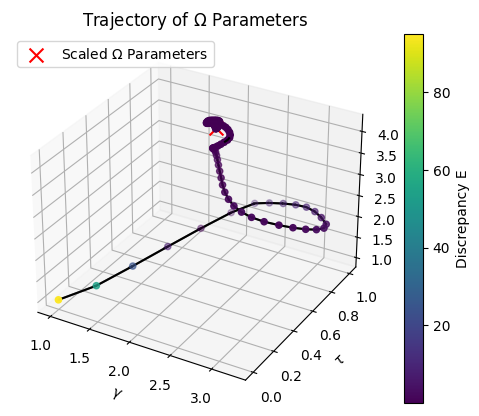

In [49]:
# plots the trajectory of the Omega parameters

Omega_trajectory = jnp.array(Omega_trajectory)
control_discrepancies = jnp.array(control_discrepancies)

# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the Omega parameters trajectory
sc = ax.scatter(Omega_trajectory[:, 0], Omega_trajectory[:, 1], Omega_trajectory[:, 2],
                c=control_discrepancies, cmap='viridis', marker='o')

# Plot the true Omega parameters
ax.scatter(scaled_Omega_parameters[0], scaled_Omega_parameters[1], scaled_Omega_parameters[2],
           color='red', marker='x', s=100, label='Scaled $\\Omega$ Parameters')

# Plot arrows and edges
for i in range(1, len(Omega_trajectory)):
    ax.plot([Omega_trajectory[i-1, 0], Omega_trajectory[i, 0]],
            [Omega_trajectory[i-1, 1], Omega_trajectory[i, 1]],
            [Omega_trajectory[i-1, 2], Omega_trajectory[i, 2]], 'gray')
    ax.quiver(Omega_trajectory[i-1, 0], Omega_trajectory[i-1, 1], Omega_trajectory[i-1, 2],
              Omega_trajectory[i, 0] - Omega_trajectory[i-1, 0],
              Omega_trajectory[i, 1] - Omega_trajectory[i-1, 1],
              Omega_trajectory[i, 2] - Omega_trajectory[i-1, 2], color='black', arrow_length_ratio=0.1)

ax.set_xlabel('$\\gamma$')
ax.set_ylabel('$\\tau$')
ax.set_zlabel('$\\nu$')
ax.set_title('Trajectory of $\\Omega$ Parameters')
fig.colorbar(sc, ax=ax, label='Discrepancy E')

# Adjust the legend position
ax.legend(loc='upper left', bbox_to_anchor=(0, 1))

plt.show()

obtained parameters: [1.9962639  0.74798506 3.9855    ]
optimized_trajectory: from learnt coefficints


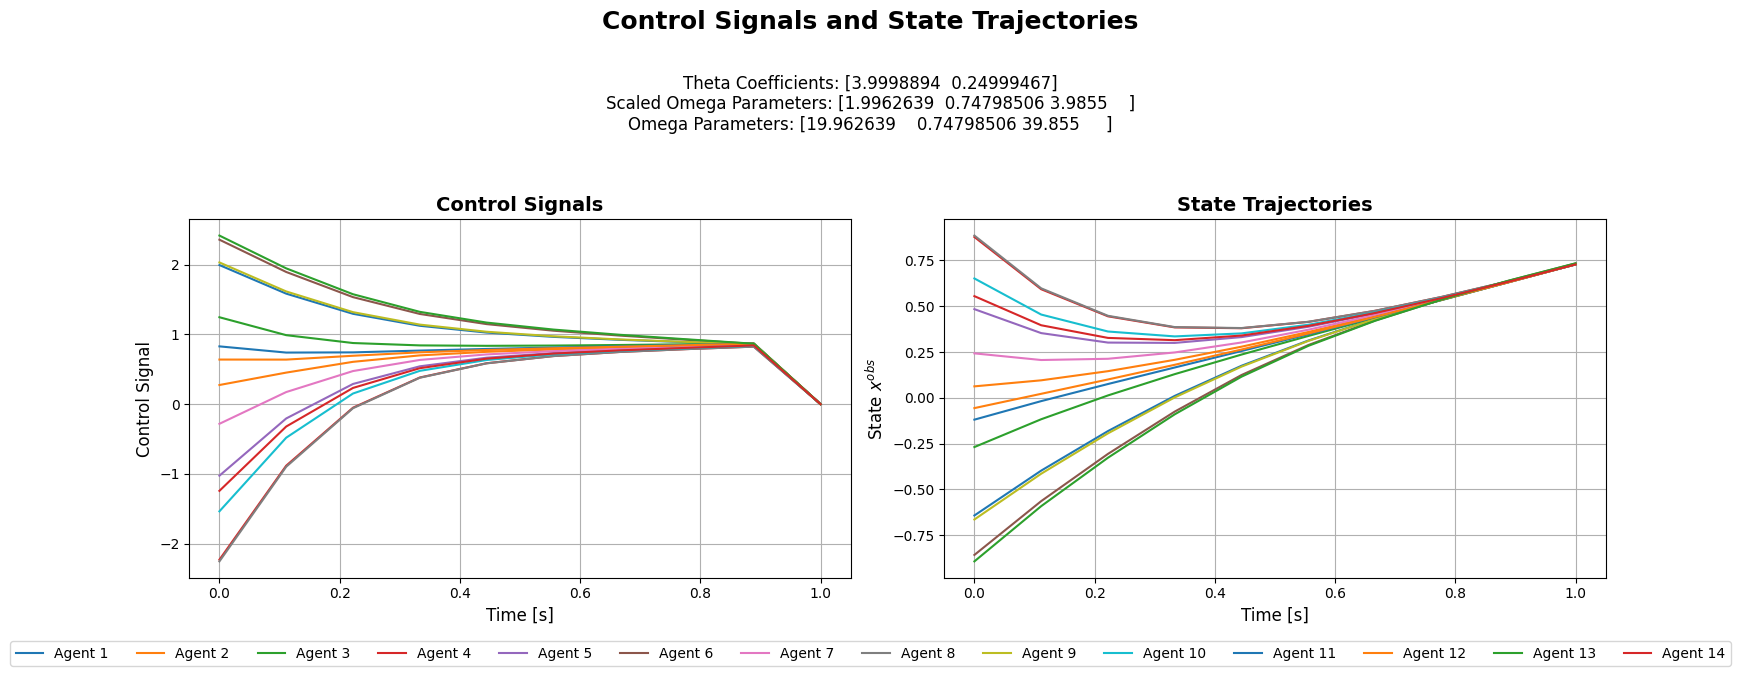

previously observed trajectory 
true beta parameters: [20.    0.75 40.  ]


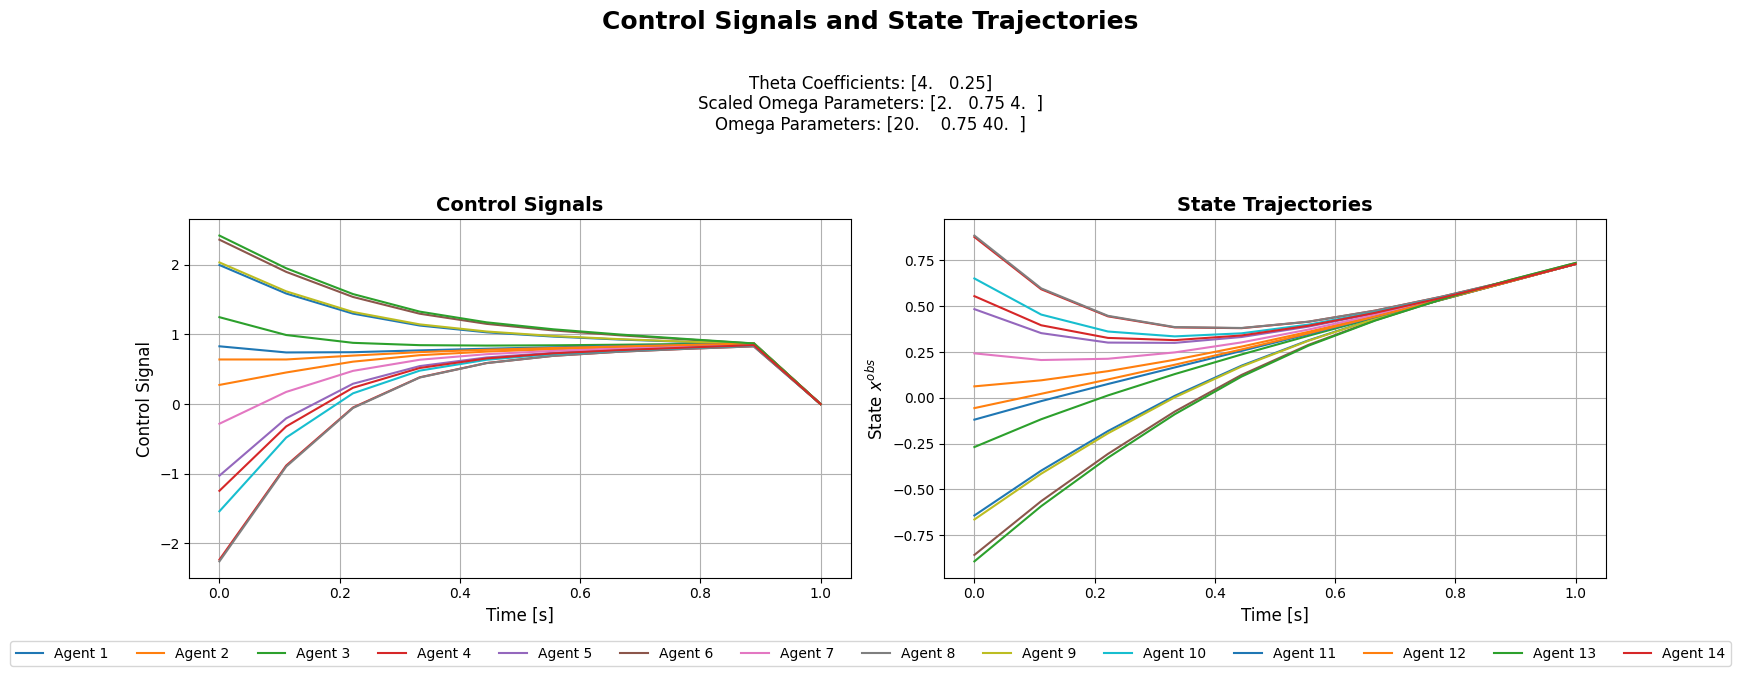

In [ ]:
# used to compare the observed data to the optimized trajectory for estimated theta and Omega parameters

print(f"estimated parameters: {Omega_parameters}")

u_star = find_u_grid(n_agents, n_steps, dt, x0, estimated_theta, Omega_parameters)
print("optimized_trajectory: from learnt coefficints")
plot_the_trajectories(u_star, x0, estimated_theta, dt, n_agents, n_steps, t, Omega_parameters)


print("previously observed trajectory ")
print(f"true (scaled down) Omega parameters: {scaled_Omega_parameters}")
plot_the_trajectories(u_observed, x0, true_theta, dt, n_agents, n_steps, t, scaled_Omega_parameters)
